<h1><font size="6" face="arial" color="#609BC4">Context</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">A current topic in system neuroscience literature is the presence of brain activity in the absence of a task condition. These task-negative, spontaneous fluctuations occur in the so-called <b>rest state</b>, and a recurring theme of these fluctuations is that they have a network structure. Because TVB uses the structural connectivity of the brain as the backbone for simulating spontaneous activity, resting-state activity and its network structure is a prime candidate for modeling in TVB.</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Objectives</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">In this mini-project, we will:
<br>
<ul>
    <li>Build a brain network model using subject-specific structural connectivity,</li> 
    <li>Simulate resting-state activity,</li>
    <li>Characterize the resting-state activity by calculating the functional connectivity (FC),</li>
</ul></font></div></p>

<h1><font size="6" face="arial" color="#609BC4">How to do it with TVB?</font></h1> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">In the first part of this tutorial, we presents the basic anatomy of a region simulation using The Virtual Brain's scripting interface.</font></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we want to do is to import the modules we will need for a simulation.</font></p>

In [52]:
import numpy as np
import matplotlib.pyplot as plt        
#from docopt import docopt
import src
import os
import nibabel as nib
import pickle
import utils
import matplotlib.gridspec as gridspec 
import time as tm
import sys  
from scipy import stats
sys.path.insert(0, '/Users/giovanni/Documents/GitHub/fufo/')
from src import analysis, simulation  # Import analysis for fcd and clustering
from tvb.simulator.lab import *



# Import a bunch of stuff to ease command line usage
# FC 
from tvb.datatypes.time_series import TimeSeriesRegion
#import tvb.analyzers.correlation_coefficient as corr_coeff
# Phase Plane
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
# ICA
import scipy.stats
from sklearn.decomposition import FastICA
# brain maps

<h1><font size="6" face="arial" color="black">1. Setting up the simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A basic simulation of TVB consists of <b>5 main components</b>. Each of these components is an object within TVB:</font>

- ## <font size="5"face="arial" color="black"> Connectivity</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start by loading and visualizing the structural connectivity matrix that represents the set of all existing connections between brain areas. Having loaded the default dataset, we can then alter the speed of signal propagation through the network:</font></div></p>

In [21]:
# Import the anatomical structural connectivity.
path='/Users/giovanni/Documents/GitHub/fufo/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(path+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

# ROIs Labels 
with open(path+'Allen_148/region_labels.txt') as f:
    content = f.readlines()   # remove whitespace characters like `\n` at the end of each line
ROIs = [ix.strip() for ix in content] 

volsize=np.loadtxt(path+'/Allen_148/volsize.txt')

file_refs= nib.load(path + 'Vol_148_Allen.nii')

A148= file_refs.get_fdata() 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [22]:
# Setup the connectivity for the simulator
conn               = connectivity.Connectivity(
    weights= A148_SC,
    region_labels=np.array(ROIs,dtype='<U128'),
    tract_lengths=A148_con.tract_lengths,
    speed=np.array(2.,dtype=np.float),
    areas =np.zeros(np.shape(A148_SC)[0]),
    centres = A148_con.centres) 

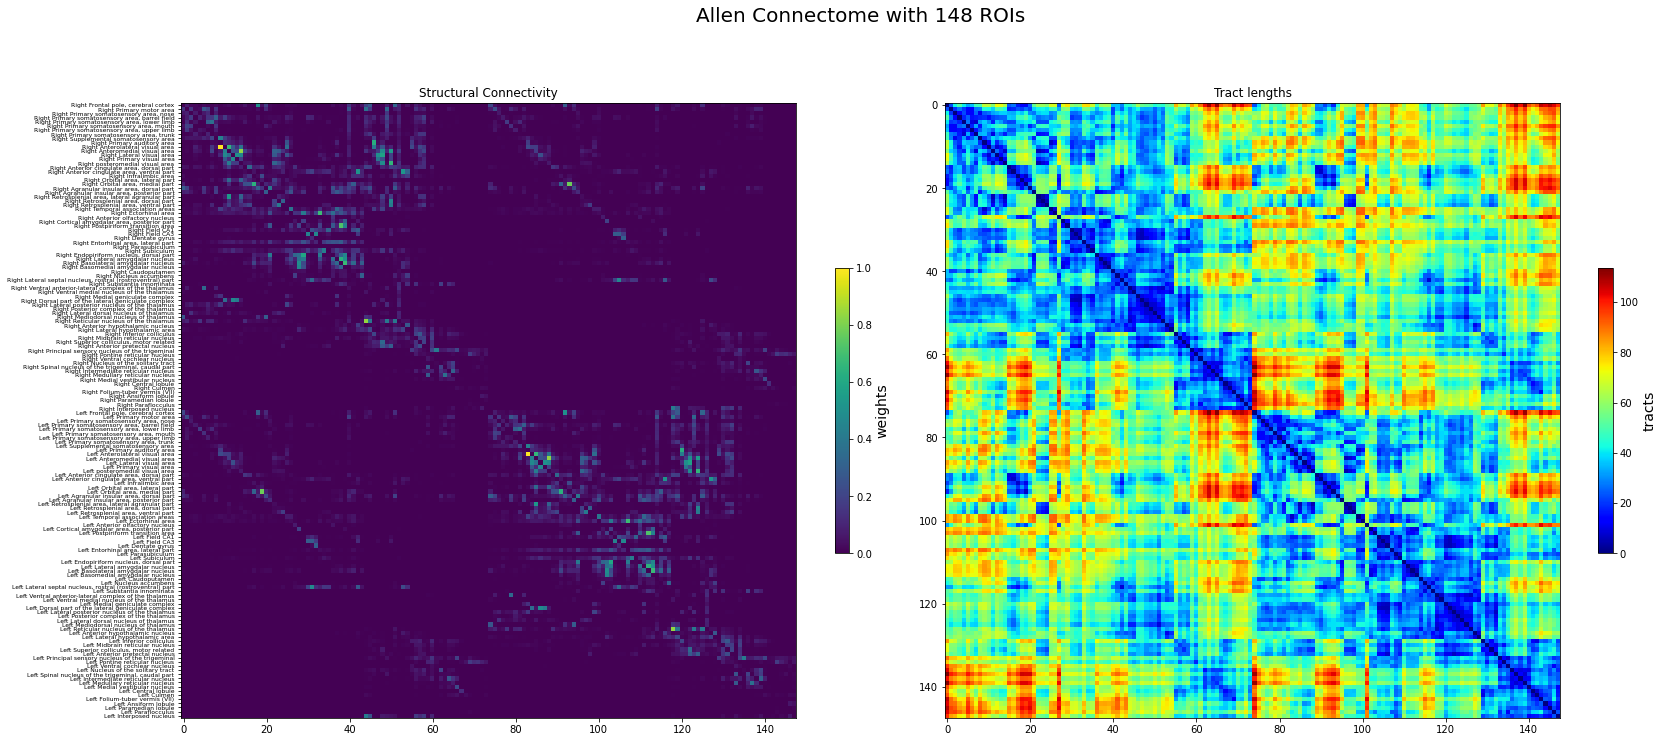

In [23]:
# Visualization
fig=plt.figure(figsize=(24,16))
fig.suptitle('Allen Connectome with 148 ROIs', fontsize=20)

# weights
plt.subplot(121)
plt.title('Structural Connectivity')
plt.imshow(A148_SC, interpolation='nearest', aspect='equal', cmap='viridis')
#plt.xticks(range(0, nregions), ROIs, fontsize=6, rotation=90)
plt.yticks(range(0, nregions), ROIs, fontsize=6)
cb=plt.colorbar(shrink=0.2)
cb.set_label('weights', fontsize=14)

#tracts
plt.subplot(122)
plt.title('Tract lengths')
plt.imshow(A148_con.tract_lengths, interpolation='nearest', aspect='equal', cmap='jet')
#plt.xticks(range(0, nregions), ROIs, fontsize=7, rotation=90)
#plt.yticks(range(0, nregions), ROIs, fontsize=7)
cb=plt.colorbar(shrink=0.2)
cb.set_label('tracts', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

- ## <font size="5" face="arial" color="black"> Model</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A set of differential equations describing the local neural dynamics. There are a number of predefined models available in TVB, as an example here we will use the <b>Montbrio,Pazo,Roxin</b> model:</font></div></p>

In [14]:
#LOCAL MODEL
eta       =-4.6
J         =14.5
Delta     =0.7
tau       =1.

mpr = models.MontbrioPazoRoxin(
    J     = np.r_[J],
    eta     = np.r_[eta],
    Delta = np.r_[Delta],
    tau   = np.r_[tau],
)

- ## <font size="5"face="arial" color="black">Coupling function</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">It is a function that is used to join the local <b>Model</b> dynamics at distinct spatial locations over the connections described in <b>Connectivity</b>. Proper setting of the parameters for this function requires some knowledge of the properties of both the model being used and the structure through which it is connected. For our present purposes, we happen to know that for this configuration of parameters of TVB's <b>Generic2dOscillator</b> connected through TVB's default connectivity matrix, a linear function with a slope of 0.0075 is a reasonable thing to use.</font></div></p>

In [15]:
# Initialise a Coupling function.
G = 0.15                       
con_coupling = coupling.Scaling(a=np.r_[G])

- ## <font size="5"face="arial" color="black">Integrator</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now that we have defined our structure and dynamics, we need to select an integration scheme. While TVB supports a number of schemes, for most purposes you should use either <b>HeunDeterministic</b> or <b>HeunStochastic</b></font></div></p> 

<p><div style="text-align: justify"><font size="4.5" face="time roman">Note that the most important thing here is to use a step size that is small enough for the integration to be numerically stable.</font></div></p>


In [25]:
# Initialise an Integrator scheme.
dt = 0.05               #integration steps [ms]

seed=42                 #different  seeds generate different random noise sequences

#heunint = integrators.HeunDeterministic(dt=dt)

nsigma = 0.0045         #standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]),noise_seed=seed)
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

- ## <font size="5"face="arial" color="black">Monitors</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The last component we need to define are some Monitors. Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we will select one simple monitor just to show the idea:
<pre></pre>

<ul>
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms.</li>
</font></div></p>

In [34]:
# Initialise some Monitors with period in physical time.

Tperiod   =10.
mon_tavg = monitors.TemporalAverage(period=1./Tperiod)        

In [42]:
# The Raw monitor takes no arguments and simply returns all the simulated data -- note: as a general rule, this monitor shouldn't be used for anything but very short simulations as the amount of data returned can become prohibitively large,</li>
# mon_raw = monitors.Raw()

# The BOLD monitor takes as argument the BOLD period and returns the convolution of the raw data with the hemodynamic Kernel built in TVB 
# mon_bold = monitors.Bold()

# In what follows we extract the BOLD signal in another way..


***

<h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The last step is to bring all these components together into a <b>Simulator</b> object. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.</font></div></p>

In [35]:
sim_len= 3000
T_len=int(float(sim_len)/Tperiod)

In [37]:
# Initialise the Simulator.

sim = simulator.Simulator(
    model=mpr,
    connectivity=conn,
    coupling=coupling.Scaling(a=np.r_[G]),
    conduction_speed=np.Inf,
    integrator=heunint,
    monitors=[mon_tavg]
)

sim.configure()

  ERROR  Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)


,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: b99f52c6-f3b8-4ee8-ba6f-38800188c914
coupling,Scaling gid: 3f53375b-b44e-470e-a659-f28178eb294a
gid,UUID('5860e812-bc39-4f79-9492-26e81ea8f1df')
initial_conditions,None
integrator,HeunStochastic gid: 7ddc6969-73b0-4f42-938d-112d66a92850
model,MontbrioPazoRoxin gid: 043891eb-1e58-4507-815a-5c7205ea903d
monitors,[]
simulation_length,1000.0


In [97]:
# Perform the simulation.

tic = tm.time()

(Tavg_time, Tavg_data), = simulation.run_nbMPR_backend(sim, simulation_length=sim_len)

'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 7.728 seconds.'

In [98]:
# remove the first 

r      = Tavg_data[:,0,:,0]
V      = Tavg_data[:,1,:,0]

***

<h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

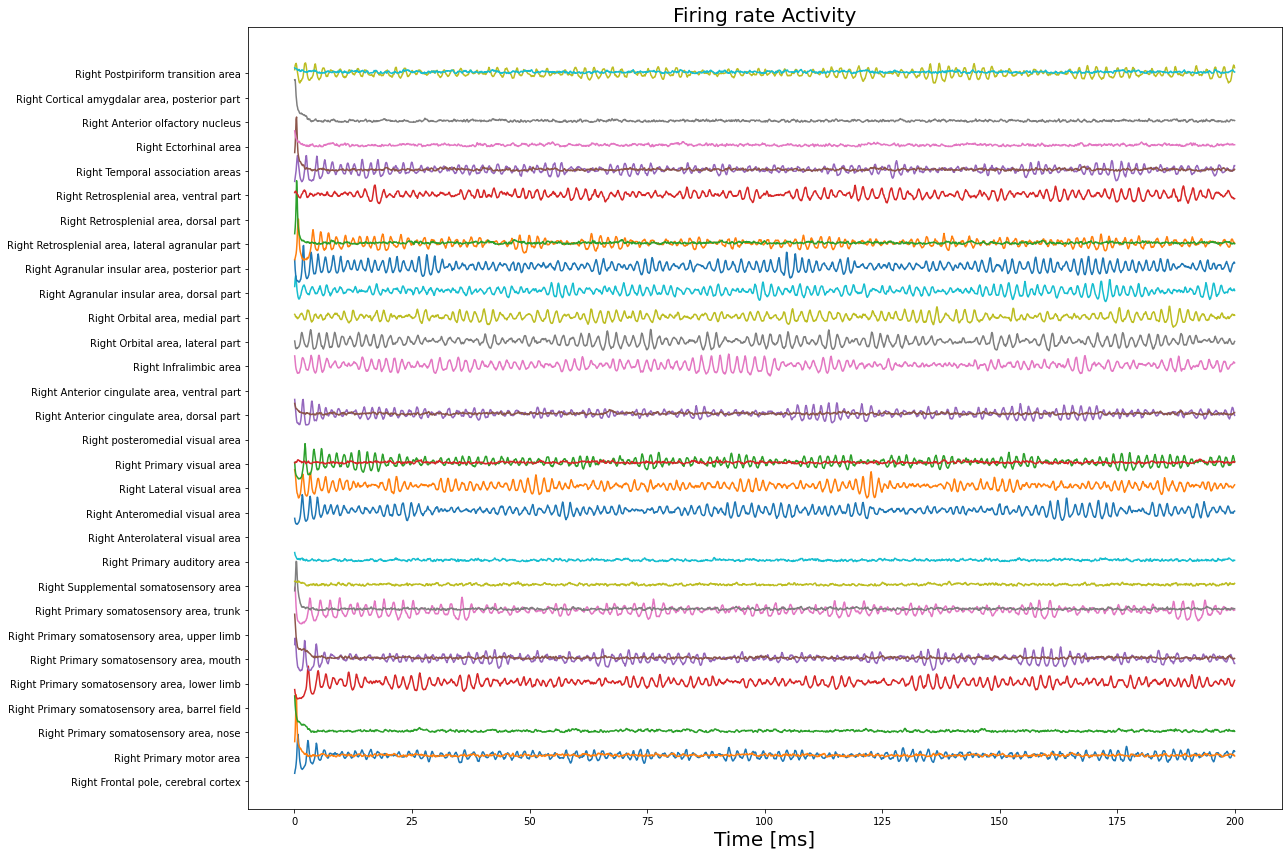

In [99]:
# Plot the raw time series 
fig = plt.figure(figsize=(18,12))
plt.plot(Tavg_time[:2000], r[:2000, :30] + np.r_[:30])
plt.title('Firing rate Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(30), ROIs[:30], fontsize=10)

plt.tight_layout()

plt.show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see there is an initial transient where the simulation stabilizes and then the activity becomes more regular. Thus we normally exclude the first time points in the simulation.</font></div></p>

In [100]:
#I remove 300 points
remove_points=9000
r=r[remove_points:]

In [101]:
# Extract the BOLD signal from the firing rate
Bperiod=300

Tavg_time *= Tperiod
Bold_time, Bold_data = simulation.tavg_to_bold(Tavg_time, Tavg_data, tavg_period=1., connectivity=sim.connectivity, svar=0, decimate=Bperiod)

Bold_data      = Bold_data[int(remove_points/Bperiod):,0,:,0]
Bold_time      = Bold_time[int(remove_points/Bperiod):]

Text(0.5, 0, 'Time [ms]')

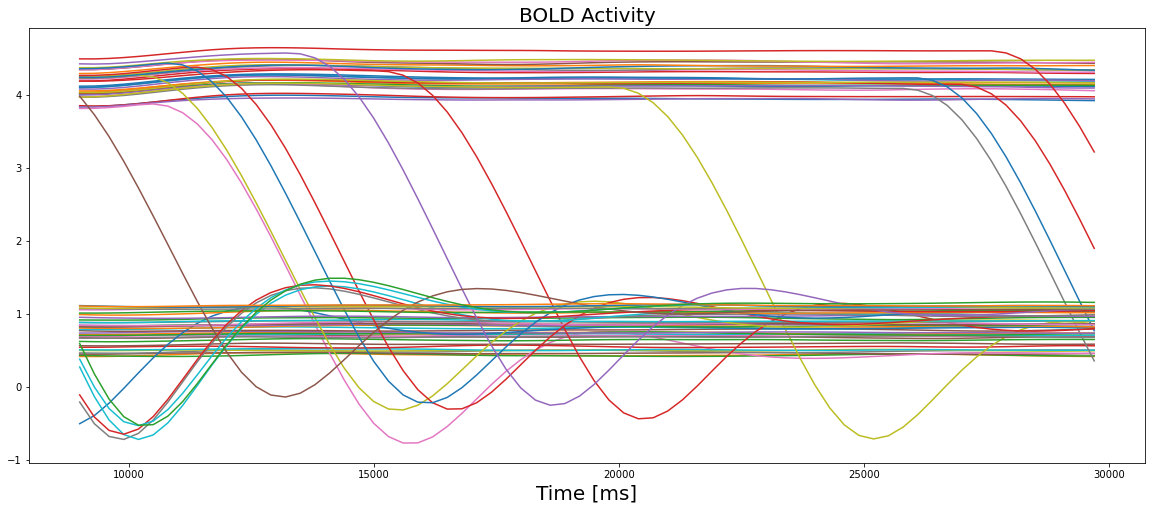

In [103]:
# Plot the temporally averaged time series
fig2 = plt.figure(figsize=(20,8))
plt.plot(Bold_time, Bold_data[:, :74] + 0.01*np.r_[:74])
plt.title('BOLD Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

<h1><font size="6"face="arial" color="black"> 2. Analyse our simulation</font></h1>

## <font size="5" face="arial" color="black"> 2.0 Edge Co-activations</font>

## <font size="5" face="arial" color="black"> 2.1 Functional Connectivity (FC)</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><b>Functional Connectivity (FC)</b> describes the connectedness of two brain regions by means of the covariance between their time series. The classic and most widely used method to infer the strength of network interactions or functional connections consists in estimating the linear (Pearson) correlation coefficient between temporal signals. If two regions activate and deactivate at the same time, there is likely a functional connection. The Pearson correlation coefficient between two series $X$ and $Y$ of size $N$ is given by the following equation:</font></div></p> 

\begin{eqnarray}
    Corr(X, Y) = \dfrac{\sum_{n=1}^{N}(X_{n} - \bar{X})(Y_{n} - \bar{Y})}{\sqrt{\sum_{n=1}^{N}(X_{n} - \bar{X})^2}\sqrt{\sum_{n=1}^{N}(Y_{n} - \bar{Y})^2}}
\end{eqnarray}

## <font size="5" face="arial" color="black"> 2.2 dynamic Functional Connectivity (dFC)</font>

In [104]:
#Define Edge coi-activations and dFC and FC
Edges_CA=src.analysis.go_edge(Bold_data)
dFC_e=np.corrcoef(Edges_CA)
FC=np.corrcoef(Bold_data.T)

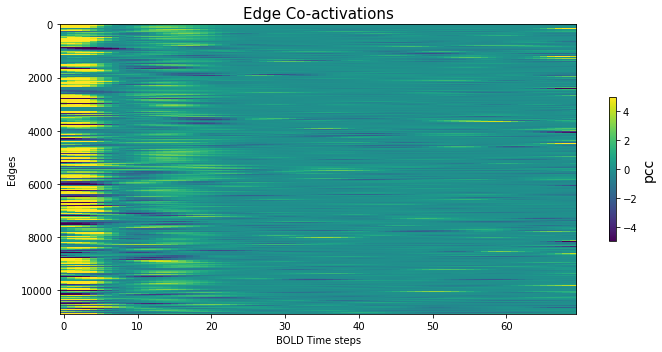

In [108]:
# Visualization
fig=plt.figure(figsize=(10,5));
plt.title('Edge Co-activations', fontsize=15);
plt.imshow(Edges_CA.T, interpolation='nearest', cmap='viridis',aspect='auto',vmin=-5,vmax=5)
cb=plt.colorbar(shrink=0.5);cb.set_label('pcc', fontsize=14);plt.xlabel('BOLD Time steps');plt.ylabel('Edges',rotation=90)
plt.tight_layout()
plt.show()

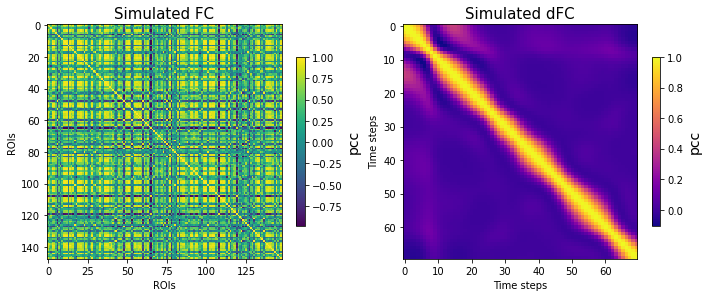

In [105]:
# Visualization
fig=plt.figure(figsize=(10,5));
plt.subplot(121)
plt.title('Simulated FC', fontsize=15);
plt.imshow(FC, interpolation='nearest', cmap='viridis')
cb=plt.colorbar(shrink=0.5);cb.set_label('pcc', fontsize=14);plt.xlabel('ROIs');plt.ylabel('ROIs',rotation=90)
plt.subplot(122)
plt.title('Simulated dFC', fontsize=15);
plt.imshow(dFC_e, interpolation='nearest', cmap='plasma')
cb=plt.colorbar(shrink=0.5);cb.set_label('pcc', fontsize=14);plt.xlabel('Time steps');plt.ylabel('Time steps',rotation=90)
plt.tight_layout()
plt.show()

- ## <font size="5"face="arial" color="black"> SC - FC comparison</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We compare the empirical SC and simulated FC matrix by adopting as a measure of similarity between the two matrices the Pearson correlation between corresponding elements of the <b>upper (or lower)</b> triangular part of the matrices.</font></div></p>

In [113]:
# Take upper triangular part of the matrices (excluding the self-connections).
TVB_SC_triu = A148_SC[np.triu_indices(nregions,1)]
FC_triu = FC[np.triu_indices(nregions,1)]

# Compute Pearson correlation coefficients between SC and FC.
pcc = np.corrcoef(TVB_SC_triu.ravel(), FC_triu.ravel())[0, 1]
pcc

0.043624211052209434